<a href="https://colab.research.google.com/github/vitroid/yamanashi-water/blob/main/air/nox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # On Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    BASEDIR="drive/MyDrive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/air/"
except:
    BASEDIR="./"

date   19202030   19204010   19206010   19441030
0   2009-04-30   8.324022  14.952450  27.263305  11.263966
1   2009-05-31   6.637838  13.287838  23.317568   8.982432
2   2009-06-30   7.313498  15.226744  19.205594  12.721335
3   2009-07-31   7.240541  15.839189  20.811798  13.851351
4   2009-08-31   7.675676  14.851351  16.679296  11.037838
..         ...        ...        ...        ...        ...
139 2020-11-30   6.746143   9.415966  22.550459   9.270308
140 2020-12-31   9.385346  11.140921        NaN  11.886179
141 2021-01-31  10.146341  13.330623  27.785150  11.585831
142 2021-02-28   6.644042   9.742081  19.666667   9.360360
143 2021-03-31   6.046385   7.168478  14.760544   7.322449

[144 rows x 5 columns]

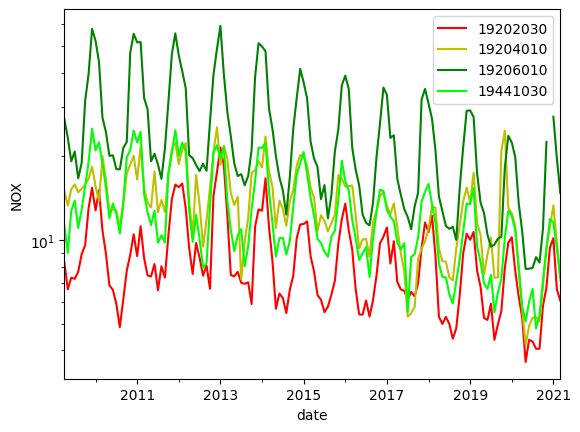

In [2]:
# 指定された局の、全期間のNOX値を抽出する。

import sys
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel("NOX")

stations = {"19202030":"r","19204010":"y","19206010":"g","19441030":"lime"}

mdf = []
for station in stations:
    dfs = []
    for year in range(2009, 2021):
        with open(f"{BASEDIR}19/{year}/j19{year}_{station}.csv") as f:
            df = pd.read_csv(f, parse_dates=[1])  # parse date time in column 1
            dfs.append(df)

    dfs = pd.concat(dfs)

    dfs.index = dfs.date

    # 月単位にグループ化します。
    grouped_df = dfs["NOX"].groupby(pd.Grouper(level="date", freq="M"))

    # 各グループの平均値を計算します。
    mean_df = grouped_df.mean()

    # 結果を表示します。
    # print(mean_df)
    mean_df.plot(color=stations[station], ax=ax,label=station)
    mdf.append(mean_df)


mdf = pd.concat(mdf, axis=1)
mdf.columns=stations
mdf = mdf.reset_index(drop=False)

    # plt.plot(mean_df["NOX"])
plt.yscale("log")
plt.legend()
mdf

* これが改良版の大気から相模湖への輸送モデルの$c(t,x)$に相当する。
   * 農地や森からの排出に周期性があるのかと思っていたが、そうではなくインプットの大気のNOX濃度自体が年周振動している。冬場に最大になるのは暖房のせいか?
* 地目面積$A_i$は`land/`で求めた。
* ブロックごとの排出窒素総量$N_{out}(t,x)$は`flow`で求めた。

これらから、地目ごと、月ごとの沈着速度係数$V_i(t)$を推定する。

例えば、12月に限定すれば、
$$N_{out}(\textrm{Dec},\textrm{red})=c(\textrm{Dec},\textrm{red})\sum_{i\in CoL}A_iV_i(\textrm{Dec})$$
|Symbol|Value|
|--|--|
|Dec|12月|
|red|Y-2,Y-3|

$V_i$は地目ごとの変数で、5つある。しかし、集水域は4種類しかない。そのため、$V_i$の値は確定しないのではないか?

In [4]:
len(mean_df)

144

発想を変え、NOX濃度と流域全窒素排出のあいだの相関を見る。

In [5]:
flows = pd.read_csv(f"{BASEDIR}../flow/4bridges2000.csv") # 2000年4月以降の252ヵ月
flows

Unnamed: 0  ('昭和橋', '流量')  ('昭和橋', '全窒素')  ('富士見橋', '流量')  \
0             0         1.0200            1.60          2.9300   
1             1         0.9700            1.30          2.6200   
2             2         0.5700            1.50          2.3800   
3             3         1.3400            1.40          3.8500   
4             4         5.1800            0.29          4.3100   
..          ...            ...             ...             ...   
247         247         4.4277            0.57          4.5551   
248         248         4.4304            0.66          4.5471   
249         249         0.9716            1.30          4.8280   
250         250         1.8441            1.00          4.7207   
251         251         2.0594            1.00          4.4706   

     ('富士見橋', '全窒素')  ('大月橋', '流量')  ('大月橋', '全窒素')  ('桂川橋', '流量')  \
0               1.20         2.0700             1.7        32.3200   
1               1.20         5.5200             1.6        39.1000   
2               1.20         2.3100             1.6        48.7000   
3               1.30         5.3000             1.7        41.0000   
4               1.10         4.8000             1.4        43.9800   
..               ...            ...             ...            ...   
247             1.00         2.9422             1.0        35.3546   
248             1.00         2.2754             1.1        32.6497   
249             0.98         1.8195             1.2        23.0379   
250             0.97         1.6346             1.3        22.1846   
251             0.88         1.4570             1.2        23.6344   

     ('桂川橋', '全窒素')  
0               1.6  
1               1.5  
2               1.5  
3               1.5  
4               1.3  
..              ...  
247             1.1  
248             1.2  
249             1.3  
250             1.2  
251             1.2  

[252 rows x 9 columns]

月平均のNOX濃度を別表からとってくる。これで2000年以降の情報がそろう。

In [6]:
import pandas as pd
import numpy as np


# read_csvが読み損じるので、自分で読む。
def read_csv(filename, sep=",", encoding="utf8"):
    rows = []
    with open(filename, encoding=encoding) as f:
        for line in f.readlines():
            cols = line.split(sep)[:143]
            rows.append(cols)
    df = pd.DataFrame(rows[1:])
    df.columns = rows[0][:143]
    print(rows[0][:143])
    return df


cols = """月平均値(ppm)_４月
同左_５月.2
同左_６月.2
同左_７月.2
同左_８月.2
同左_９月.2
同左_10月.2
同左_11月.2
同左_12月.2
同左_１月.2
同左_２月.2
同左_３月.2
""".splitlines()

# 2008年のデータはコラム名をつけまちがっている!!!信じられん。

stations = [19202030, 19204010, 19206010]

nox = []
for year in range(2000, 2021):
    if year >= 2003:
        cols = "月平均値(ppm)_４月,月平均値(ppm)_５月,月平均値(ppm)_６月,月平均値(ppm)_７月,月平均値(ppm)_８月,月平均値(ppm)_９月,月平均値(ppm)_10月,月平均値(ppm)_11月,月平均値(ppm)_12月,月平均値(ppm)_１月,月平均値(ppm)_２月,月平均値(ppm)_３月".split(
            ","
        )
    filename = f"{BASEDIR}../TD20231218_155555_51/TD{year}0419.txt"
    cols_in_file = list(
        pd.read_csv(
            filename,
            sep=",",
            nrows=1,
            encoding="cp932",
        )
    )
    print(len(cols_in_file))
    df = pd.read_csv(
        filename,
        encoding="cp932",
        sep=",",
        usecols=cols_in_file,
    )
    df = df.loc[:, ~df.columns.duplicated()]
    print(year, df)
    for i, col in enumerate(cols):
        month = i + 4
        y = year
        if month > 12:
            y += 1
            month -= 12
        row = []
        for station in stations:
            rows = df[df["測定局コード"] == station]
            if len(rows) > 0:
                row.append(rows.iloc[0][col])
            else:
                row.append(np.NaN)
        print(row)
        nox.append([float(x) for x in row])

nox = pd.DataFrame(nox, columns=stations)

nox

175
2000     測定年度  項目種類コード  項目コード_数字 項目コード_英数字  測定方法コード  都道府県コード 都道府県名        同左_ローマ字  \
0   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
1   2000        1         4       NOX        2       19   山梨県  Yamanashi-keｎ   
2   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
3   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
4   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
5   2000        1         4       NOX        2       19   山梨県  Yamanashi-keｎ   
6   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
7   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
8   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
9   2000        1         4       NOX        1       19   山梨県  Yamanashi-keｎ   
10  2000        1         4       NOX        2       19   山梨県  Yamanashi-keｎ   

    市区町村コード  市区町村名  ... Unname

19202030  19204010  19206010
0       0.011     0.024     0.030
1       0.009     0.027     0.024
2       0.011     0.029     0.027
3       0.010     0.023     0.023
4       0.011     0.023     0.022
..        ...       ...       ...
247     0.007     0.009     0.023
248     0.009     0.011       NaN
249     0.010     0.013     0.028
250     0.007     0.010     0.020
251     0.006     0.007     0.015

[252 rows x 3 columns]

<Axes: >

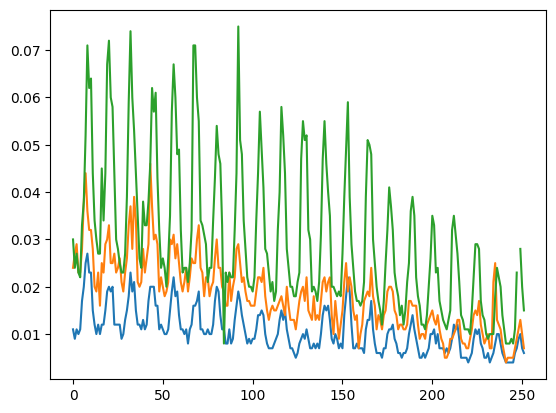

In [7]:
nox[19202030].plot()
nox[19204010].plot()
nox[19206010].plot()


In [8]:
flows = pd.read_csv(f"{BASEDIR}../flow/4bridges2000.csv") # 2000年4月以降の252ヵ月
flows

Unnamed: 0  ('昭和橋', '流量')  ('昭和橋', '全窒素')  ('富士見橋', '流量')  \
0             0         1.0200            1.60          2.9300   
1             1         0.9700            1.30          2.6200   
2             2         0.5700            1.50          2.3800   
3             3         1.3400            1.40          3.8500   
4             4         5.1800            0.29          4.3100   
..          ...            ...             ...             ...   
247         247         4.4277            0.57          4.5551   
248         248         4.4304            0.66          4.5471   
249         249         0.9716            1.30          4.8280   
250         250         1.8441            1.00          4.7207   
251         251         2.0594            1.00          4.4706   

     ('富士見橋', '全窒素')  ('大月橋', '流量')  ('大月橋', '全窒素')  ('桂川橋', '流量')  \
0               1.20         2.0700             1.7        32.3200   
1               1.20         5.5200             1.6        39.1000   
2               1.20         2.3100             1.6        48.7000   
3               1.30         5.3000             1.7        41.0000   
4               1.10         4.8000             1.4        43.9800   
..               ...            ...             ...            ...   
247             1.00         2.9422             1.0        35.3546   
248             1.00         2.2754             1.1        32.6497   
249             0.98         1.8195             1.2        23.0379   
250             0.97         1.6346             1.3        22.1846   
251             0.88         1.4570             1.2        23.6344   

     ('桂川橋', '全窒素')  
0               1.6  
1               1.5  
2               1.5  
3               1.5  
4               1.3  
..              ...  
247             1.1  
248             1.2  
249             1.3  
250             1.2  
251             1.2  

[252 rows x 9 columns]

In [10]:
# Google Colab
! pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b51b7a3d84ba65ff78b985f6bdee180b7829fe60a1d5f573285142b255512d14
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


[[1.         0.47462818]
 [0.47462818 1.        ]]


Text(0.5, 1.0, '桂川橋')

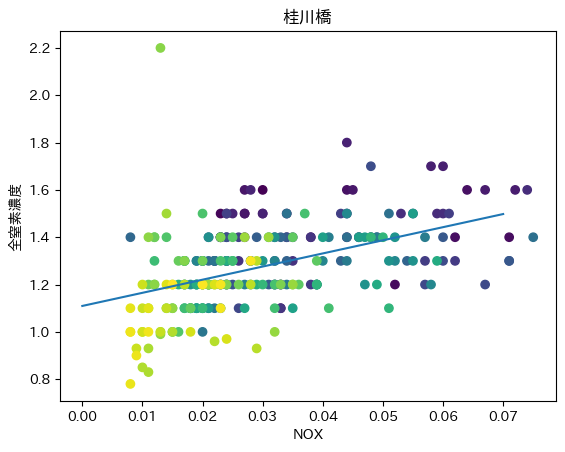

In [11]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.scatter(nox[19206010].fillna(method="ffill").to_numpy(), flows["('桂川橋', '全窒素')"],
                c=flows.index,
    cmap="viridis",
    vmin=0,
    vmax=251,
)
print(np.corrcoef(nox[19206010].fillna(method="ffill").to_numpy(), flows["('桂川橋', '全窒素')"]))
a, b = np.polyfit(nox[19206010].fillna(method="ffill").to_numpy(), flows["('桂川橋', '全窒素')"], 1)
X = np.linspace(0,0.07,100)
plt.plot(X, X*a+b, "-")
plt.xlabel("NOX")
plt.ylabel("全窒素濃度")
plt.title("桂川橋")

[[1.         0.41450748]
 [0.41450748 1.        ]]


Text(0.5, 1.0, '富士見橋')

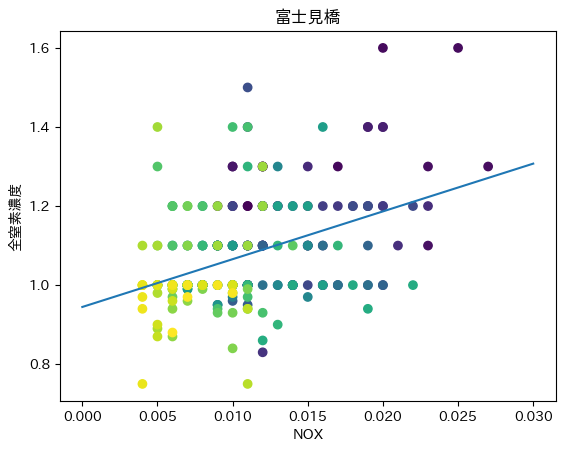

In [12]:
plt.scatter(nox[19202030].fillna(method="ffill").to_numpy(), flows["('富士見橋', '全窒素')"],
                c=flows.index,
    cmap="viridis",
    vmin=0,
    vmax=251,
)
print(np.corrcoef(nox[19202030].fillna(method="ffill").to_numpy(), flows["('富士見橋', '全窒素')"]))
a, b = np.polyfit(nox[19202030].fillna(method="ffill").to_numpy(), flows["('富士見橋', '全窒素')"], 1)
X = np.linspace(0,0.03,100)
plt.plot(X, X*a+b, "-")
plt.xlabel("NOX")
plt.ylabel("全窒素濃度")
plt.title("富士見橋")

[[1.         0.62693065]
 [0.62693065 1.        ]]


Text(0.5, 1.0, '大月橋')

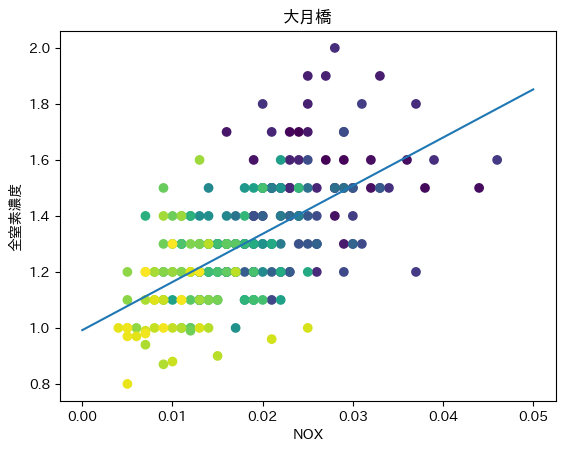

In [13]:
plt.scatter(nox[19204010].fillna(method="ffill").to_numpy(), flows["('大月橋', '全窒素')"],
                c=flows.index,
    cmap="viridis",
    vmin=0,
    vmax=251,
)
print(np.corrcoef(nox[19204010].fillna(method="ffill").to_numpy(), flows["('大月橋', '全窒素')"]))
a, b = np.polyfit(nox[19204010].fillna(method="ffill").to_numpy(), flows["('大月橋', '全窒素')"], 1)
X = np.linspace(0,0.05,100)
plt.plot(X, X*a+b, "-")
plt.xlabel("NOX")
plt.ylabel("全窒素濃度")
plt.title("大月橋")

In [14]:
a,b

(17.194967823474066, 0.9921505074734661)

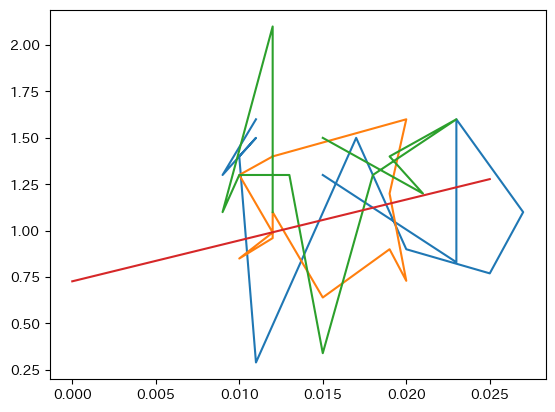

In [15]:

plt.plot(nox[19202030].fillna(method="ffill").to_numpy()[0:12], flows["('昭和橋', '全窒素')"][:12])
plt.plot(nox[19202030].fillna(method="ffill").to_numpy()[12:24], flows["('昭和橋', '全窒素')"][12:24])
plt.plot(nox[19202030].fillna(method="ffill").to_numpy()[24:36], flows["('昭和橋', '全窒素')"][24:36])
# plt.scatter(nox.fillna(method="ffill").to_numpy(), flows["('昭和橋', '全窒素')"],
#                 c=flows.index,
#     cmap="viridis",
#     vmin=0,
#     vmax=251,
# )
np.corrcoef(nox[19202030].fillna(method="ffill").to_numpy(), flows["('昭和橋', '全窒素')"])
a, b = np.polyfit(nox[19202030].fillna(method="ffill").to_numpy(), flows["('昭和橋', '全窒素')"], 1)
X = np.linspace(0,0.025,100)
plt.plot(X, X*a+b, "-")


In [16]:
a,b

(22.021400590335343, 0.7272137087145198)

In [17]:
nox.fillna(method="ffill").to_numpy()

array([[0.011, 0.024, 0.03 ],
       [0.009, 0.027, 0.024],
       [0.011, 0.029, 0.027],
       [0.01 , 0.023, 0.023],
       [0.011, 0.023, 0.022],
       [0.017, 0.028, 0.033],
       [0.02 , 0.038, 0.038],
       [0.025, 0.044, 0.052],
       [0.027, 0.036, 0.071],
       [0.023, 0.032, 0.062],
       [0.023, 0.032, 0.064],
       [0.015, 0.028, 0.044],
       [0.012, 0.02 , 0.034],
       [0.01 , 0.019, 0.03 ],
       [0.012, 0.023, 0.027],
       [0.01 , 0.016, 0.027],
       [0.012, 0.025, 0.045],
       [0.012, 0.023, 0.034],
       [0.015, 0.029, 0.044],
       [0.019, 0.03 , 0.067],
       [0.02 , 0.033, 0.072],
       [0.019, 0.025, 0.06 ],
       [0.02 , 0.025, 0.058],
       [0.012, 0.027, 0.044],
       [0.012, 0.023, 0.03 ],
       [0.012, 0.024, 0.028],
       [0.012, 0.026, 0.025],
       [0.009, 0.021, 0.023],
       [0.01 , 0.019, 0.023],
       [0.013, 0.023, 0.027],
       [0.015, 0.026, 0.039],
       [0.018, 0.033, 0.059],
       [0.023, 0.037, 0.074],
       [0.

2変数線形回帰により、背景と大気質依存成分を分離する。

In [20]:
import numpy as np
import scipy
import japanize_matplotlib
import plotly.graph_objects as go
import plotly.io as pio

def trend(cF, B, C, D, E):
    c, F = cF
    return c * (B + C * F) + D + E * F


bridges = {
    "昭和橋": 19202030,
    "富士見橋": 19202030,
    "大月橋": 19204010,
    "桂川橋": 19206010,
}

for bridge, station in bridges.items():
    flowcol = f"('{bridge}', '流量')"
    noxcol = f"('{bridge}', '全窒素')"

    # NOX in the air
    c = nox[station].ffill()

    # River flow
    F = flows[flowcol]

    # N load
    N = flows[flowcol] * flows[noxcol]

    popt, pcov = scipy.optimize.curve_fit(trend, (c, F), N)
    print(popt)

    X = np.linspace(0, np.max(c), 100)
    Y = np.linspace(0, np.max(F), 100)
    X, Y = np.meshgrid(X, Y)
    Z = trend((X, Y), *popt)

    surface = go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale="Viridis",
    )

    rawdata = go.Scatter3d(x=c, y=F, z=N, mode="markers")

    mobile = go.Surface(
        x=X,
        y=Y,
        z=trend((X,Y), popt[0], popt[1],0,0),
        colorscale='blues'
    )

    static = go.Surface(
        x=X,
        y=Y,
        z=trend((X,Y), 0,0,popt[2], popt[3]),
        colorscale="greens",
    )


    fig = go.Figure(data=[surface, rawdata, mobile, static])
    fig.update_layout(
        scene=dict(
            xaxis_title="c",
            yaxis_title="F",
            zaxis_title="N",
        ),
        title=dict(text=bridge),
    )
    fig.show()
    pio.write_html(fig, file=f"{bridge}.html", auto_open=True)


[32.61007665 22.3633393   0.58296552  0.15140205]


[-86.67760427  33.24371116   0.70736326   0.77959926]


[13.5700877  12.595816    0.2125548   0.94109483]


[14.02623686  5.2793247   5.1206462   0.95065843]


オレンジの点は実測値、一番上の面がフィッティング、緑の面が大気以外(畑と森)からの寄与(流量のみに依存するので平坦)、青が大気からの寄与(流量FとNOX濃度cの両方に依存するので曲がる)

